<a href="https://colab.research.google.com/github/anandrao1962/ALLM-S20204-mtbogush-NASA-RUL-Assignment/blob/main/Copy_of_NLX_Assignment_1_Sarthak_Bisht.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Adapted from Starter Notebook

!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8 torchsummaryX --quiet
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"khushalidaga08","key":"c7aaa2a8acee7e33b56fe4195f198b4d"}')
    # Put your kaggle username & key here if the existing one doesn't work
    # You may have to join the kaggle competition
    # https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download behrad3d/nasa-cmaps --quiet
! mkdir train
! unzip -qq nasa-cmaps.zip -d train

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchsummaryX import summary
from tqdm import tqdm

# As the dataset is quite small, we can train on cpu as well
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# FD001

In [ ]:
dataset    = 'FD001'

# Datasets FD001 to FD004 incorpoate increasing level of complexity and maybe
# used to incrementally learn the effects of faults and operational conditions
# FD001 to FD003 can be regarded as special cases of FD004

# Datasets  , # Fault Models              , # Conditions    , # Train , # Test
# FD001     , # 1 (HPC Degradation)       , # 1 (Sea Level) , # 100   , # 100
# FD002     , # 1 (HPC Degradation)       , # 6             , # 260   , # 259
# FD003     , # 2 (HPC, Fan Degradation)  , # 1 (Sea Level) , # 100   , # 100
# FD004     , # 2 (HPC, Fan Degradation)  , # 6             , # 249   , # 248

train_file = f'/content/train/CMaps/train_{dataset}.txt'
test_file  = f'/content/train/CMaps/test_{dataset}.txt'
truth_file = f'/content/train/CMaps/RUL_{dataset}.txt'

train_df = pd.read_csv(train_file, header = None, sep = ' ').iloc[:, :-2]
test_df  = pd.read_csv(test_file , header = None, sep = ' ').iloc[:, :-2]
truth_df = pd.read_csv(truth_file, header = None)

column_names = [
    # 6 different flight conditions were simulated using 3 operatinal settings
    # Symbol        , # Description
    'unit_ID'       , # ID of each engine instance
    'cycles'        , # Time series (cycles) of sensed measurements
    'alt'           , # Altitude (0-42K ft.)
    'mach'          , # Mach number (0-0.84)
    'tra'           , # Throttle Resolver Angle (20-100)

    # 14 input parameters for engine configs in C-MAPSS
    # Sybmbol       , # Description
    # W_f           , # Fuel flow
    # fan_eff_mod   , # Fan efficiency modifier
    # fan_flow_mod  , # Fan flow modifier
    # fan_PR_mod    , # Fan pressure-ratio modifier
    # LPC_eff_mod   , # LPC efficiency modifier
    # LPC_flow_mod  , # LPC flow modifier
    # LPC_PR_mod    , # LPC pressure-ratio modifier
    # HPC_eff_mod   , # HPC efficiency modifier
    # HPC_flow_mod  , # HPC flow modifier
    # HPC_PR_mod    , # HPC pressure-ratio modifier
    # HPT_eff_mod   , # HPT efficiency modifier
    # HPT_flow_mod  , # HPT flow modifier
    # LPT_eff_mod   , # LPT efficiency modifier
    # LPT_flow_mod  , # HPT flow modifier

    # 21 out of 58 output parameters exposed in the dataset
    # Symbol        , # Description                     , # Units
    'T2'            , # Total temperature at fan inlet  , # °R
    'T24'           , # Total temperature at LPC outlet , # °R
    'T30'           , # Total temperature at HPC outlet , # °R
    'T50'           , # Total temperature at LPT outlet , # °R
    'P2'            , # Pressure at fan inlet           , # psia
    'P15'           , # Total pressure in bypass-duct   , # psia
    'P30'           , # Total pressure at HPC outlet    , # psia
    'Nf'            , # Physical fan speed              , # rpm
    'Nc'            , # Physical core speed             , # rpm
    'epr'           , # Engine pressure ratio (P50/P2)  , # --
    'Ps30'          , # Static pressure at HPC outlet   , # psia
    'phi'           , # Ratio of fuel flow to Ps30      , # pps/psi
    'NRf'           , # Corrected fan speed             , # rpm
    'NRc'           , # Corrected core speed            , # rpm
    'BPR'           , # Bypass Ratio                    , # --
    'farB'          , # Burner fuel-air ratio           , # --
    'htBleed'       , # Bleed Enthalpy                  , # --
    'Nf_dmd'        , # Demanded fan speed              , # rpm
    'PCNfR_dmd'     , # Demanded corrected fan speed    , # rpm
    'W31'           , # HPT coolant bleed               , # lbm/s
    'W32'           , # LPT coolant bleed               , # lbm/s
    ]

    # Hidden parameters for calcuating the Health Index
    # Symbol        , # Description                     , # Units
    # T48 (EGT)     , # Total temperature at HPT outlet , # °R
    # SmFan         , # Fan stall margin                , # --
    # SmLPC         , # LPC stall margin                , # --
    # SmHPC         , # HPC stall margin                , # --

train_df.columns = column_names
test_df.columns = column_names
truth_df.columns = ['RUL']
truth_df['unit_ID'] = truth_df.index + 1


train_df['RUL'] = train_df.groupby('unit_ID')['cycles'].transform('max')
train_df['RUL'] = train_df['RUL'] - train_df['cycles']
test_df = test_df.merge(truth_df, left_on='unit_ID', right_on='unit_ID', how='left')
test_df['RUL'] += test_df.groupby('unit_ID')['cycles'].transform('max')
test_df['RUL'] = test_df['RUL'] - test_df['cycles']

print(train_df.shape, test_df.shape, truth_df.shape)

(20631, 27) (13096, 27) (100, 2)


Text(0.5, 1.0, 'Test')

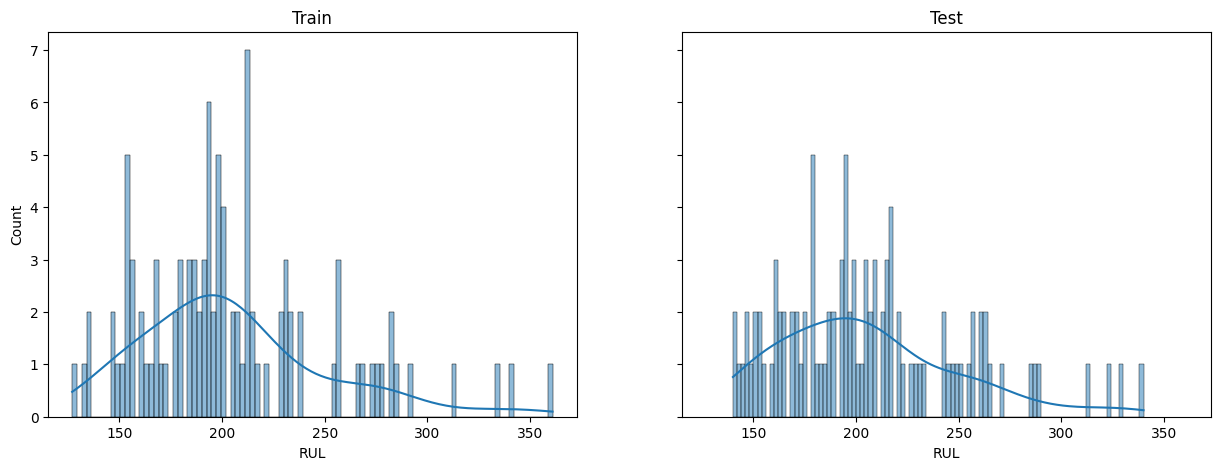

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
sns.histplot(train_df.groupby('unit_ID')['RUL'].max(), kde=True, bins=train_df['unit_ID'].unique().shape[0], ax=axes[0])
sns.histplot(test_df.groupby('unit_ID')['RUL'].max(), kde=True, bins=test_df['unit_ID'].unique().shape[0], ax=axes[1])
axes[0].set_title('Train')
axes[1].set_title('Test')

Text(0.5, 1.0, 'Test')

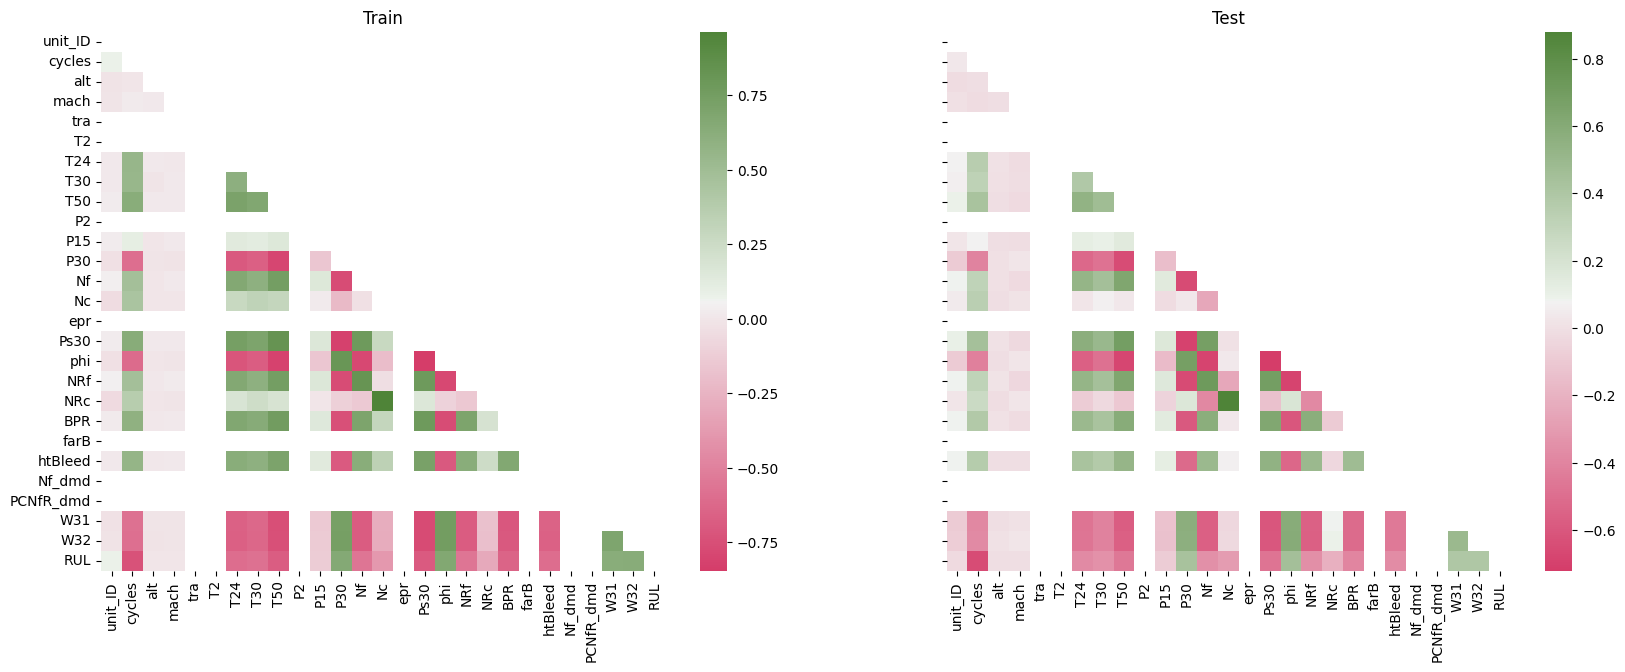

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
sns.heatmap(train_df.corr(),
            mask=np.triu(np.ones_like(train_df.corr(), dtype=bool)),
            cmap=sns.diverging_palette(0, 120, as_cmap=True),
            ax = axes[0]
            )
axes[0].set_title('Train')
sns.heatmap(test_df.corr(),
            mask=np.triu(np.ones_like(test_df.corr(), dtype=bool)),
            cmap=sns.diverging_palette(0, 120, as_cmap=True),
            ax = axes[1]
            )
axes[1].set_title('Test')

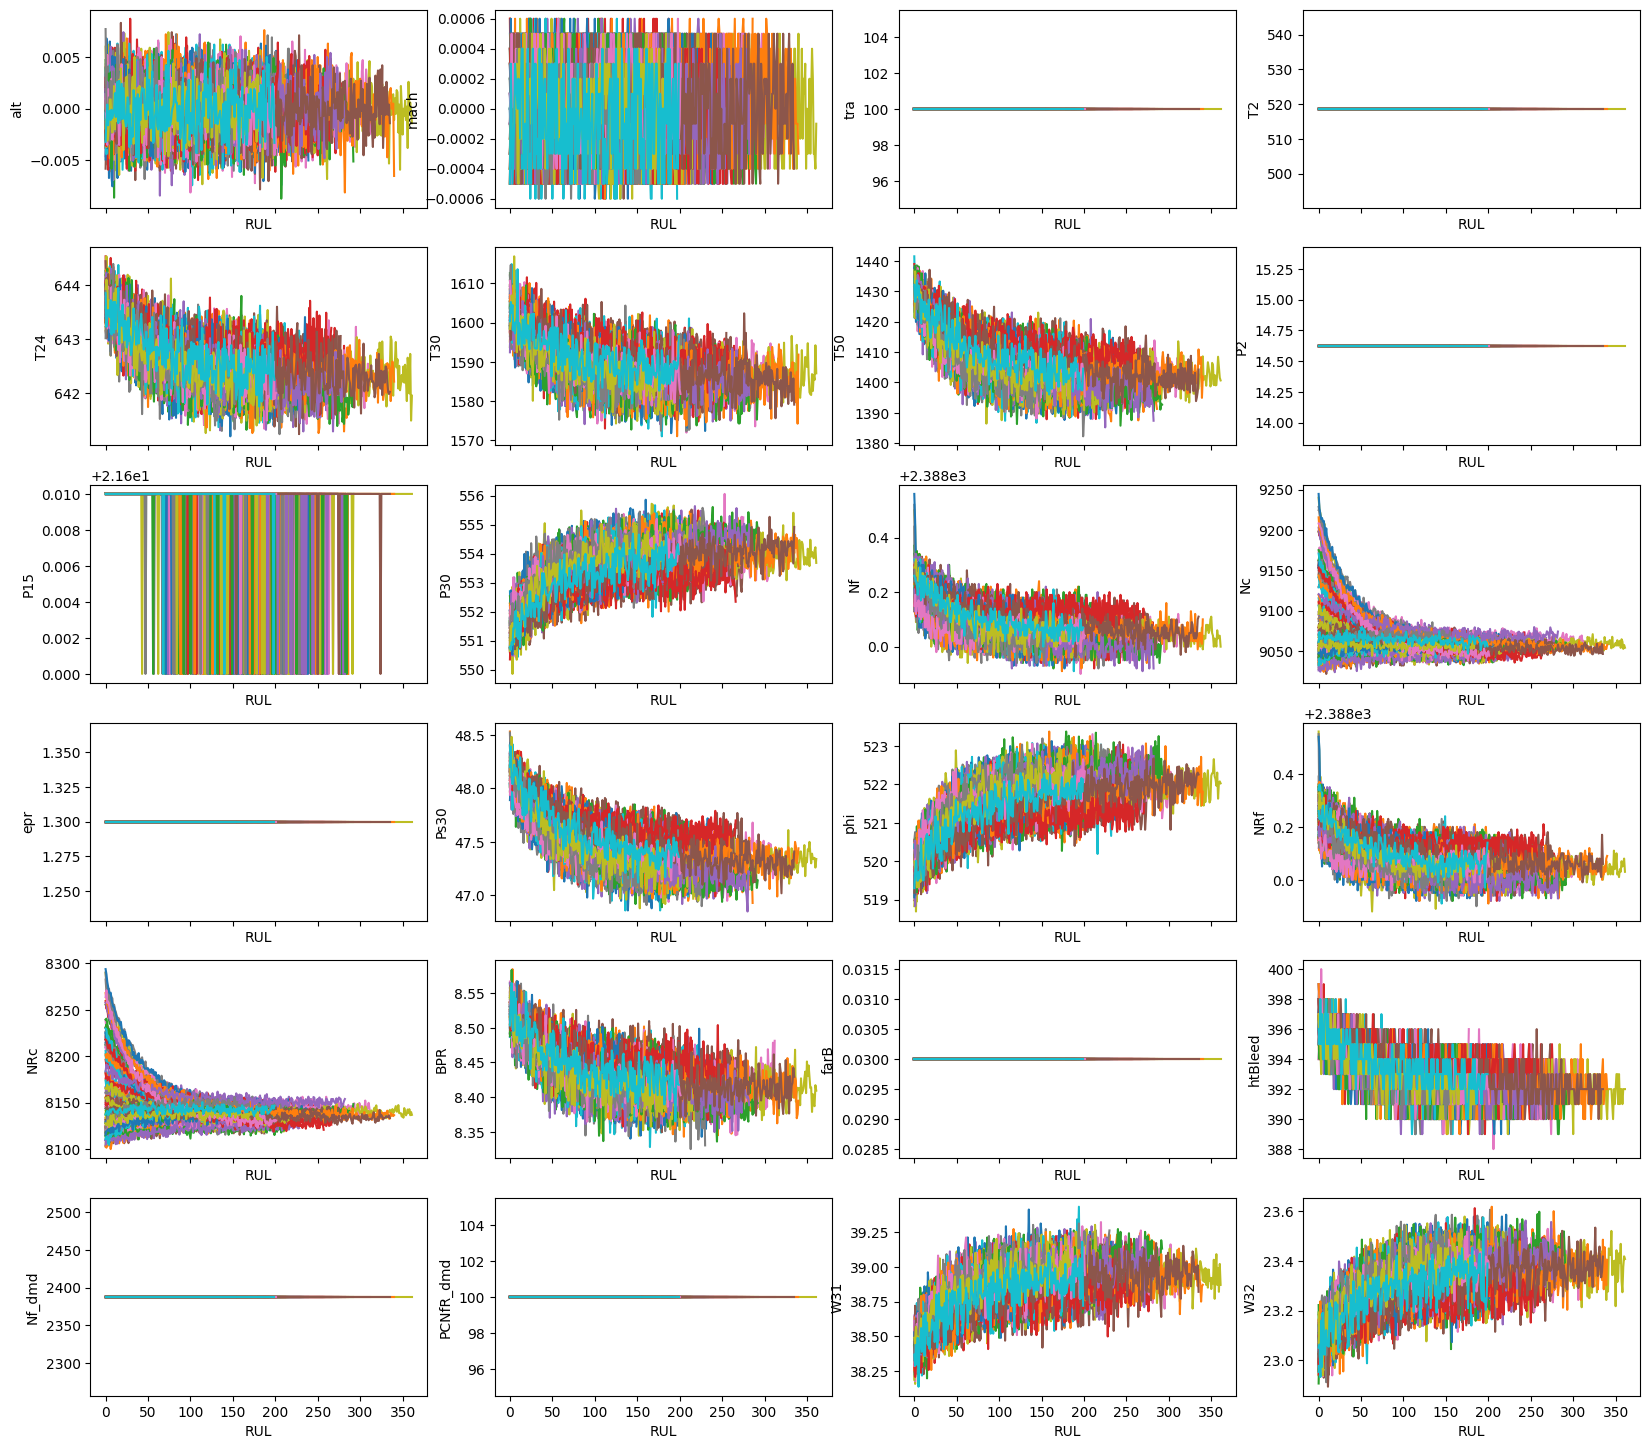

In [ ]:
df = train_df
fig, axes = plt.subplots(6, 4, figsize=(20, 18), sharex=True)

for ax, col in zip(axes.flatten(), df.columns[2:-1]):
    for unit_id in df['unit_ID'].unique():
        unit_data = df[df['unit_ID'] == unit_id]
        ax.plot(unit_data['RUL'], unit_data[col])
    ax.set_ylabel(col)
    ax.set_xlabel('RUL')

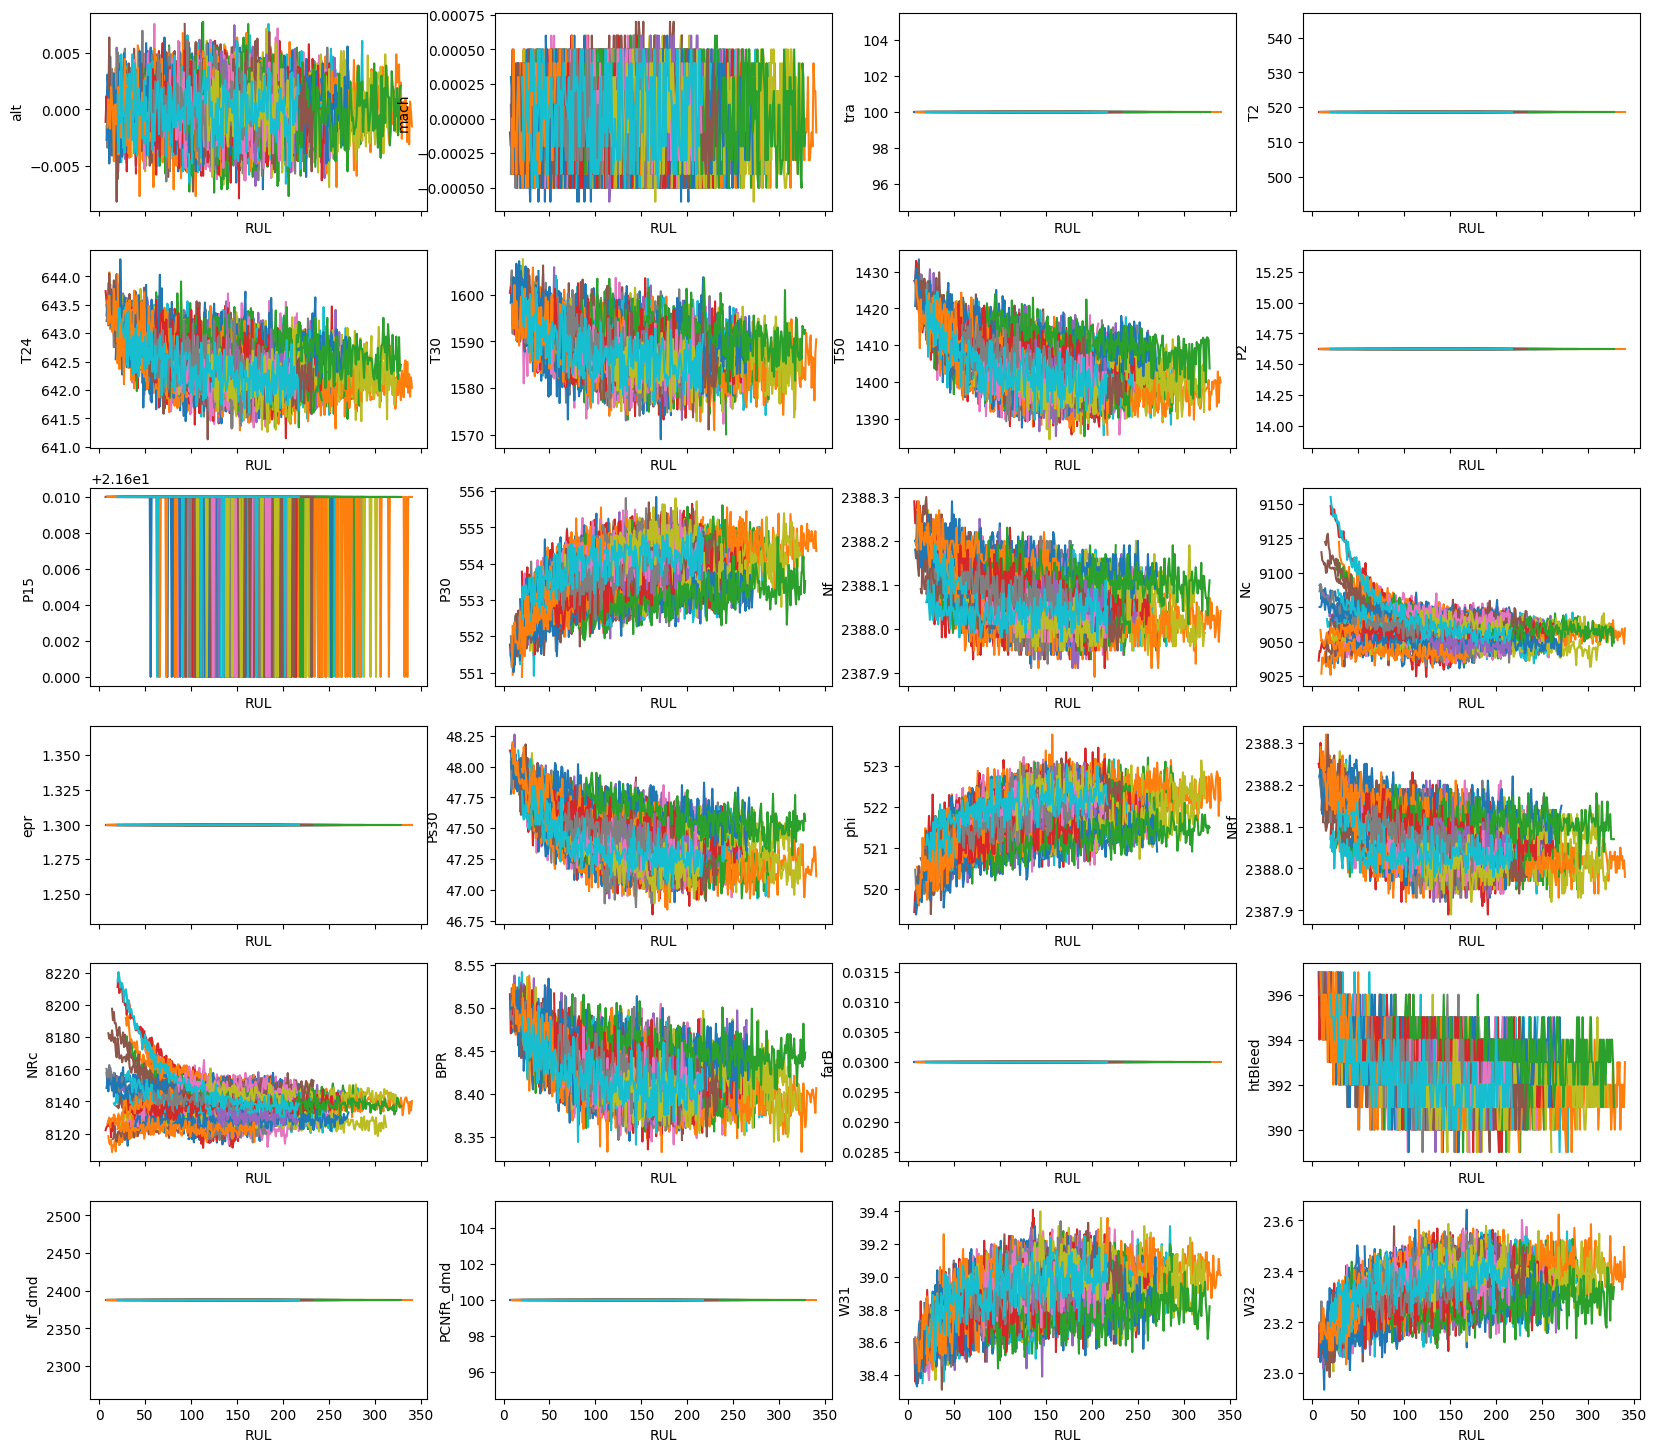

In [ ]:
df = test_df
fig, axes = plt.subplots(6, 4, figsize=(20, 18), sharex=True)

for ax, col in zip(axes.flatten(), df.columns[2:-1]):
    for unit_id in df['unit_ID'].unique():
        unit_data = df[df['unit_ID'] == unit_id]
        ax.plot(unit_data['RUL'], unit_data[col])
    ax.set_ylabel(col)
    ax.set_xlabel('RUL')

As can be seen in previous graphs, the operating parameter **tra** and and sensor values **T2, P2, epr, farB, Nf_dmd** and **PCNfR_dmd** are not varying with the traget variable **RUL** and hence can be removed from the dataset. Additionally, **P15** is behaving as a step function with very little correlation with **RUL** and can also be dropped.

In [ ]:
drop_col = ['tra', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
train_df[drop_col].describe().transpose()

count         mean           std      min      25%      50%  \
tra        20631.0   100.000000  0.000000e+00   100.00   100.00   100.00   
T2         20631.0   518.670000  6.537152e-11   518.67   518.67   518.67   
P2         20631.0    14.620000  3.394700e-12    14.62    14.62    14.62   
P15        20631.0    21.609803  1.388985e-03    21.60    21.61    21.61   
epr        20631.0     1.300000  4.660829e-13     1.30     1.30     1.30   
farB       20631.0     0.030000  1.556432e-14     0.03     0.03     0.03   
Nf_dmd     20631.0  2388.000000  0.000000e+00  2388.00  2388.00  2388.00   
PCNfR_dmd  20631.0   100.000000  0.000000e+00   100.00   100.00   100.00   

               75%      max  
tra         100.00   100.00  
T2          518.67   518.67  
P2           14.62    14.62  
P15          21.61    21.61  
epr           1.30     1.30  
farB          0.03     0.03  
Nf_dmd     2388.00  2388.00  
PCNfR_dmd   100.00   100.00

Min-max scaling has been performed to normalize the data. Alternatively, Z-Score normalization could also be performed.

We also performed exponential smoothing to reduce high-frequency noise from the sensor values.

In [ ]:
# Drop unnecessary columns
train_df = train_df.drop(drop_col, axis = 1)
test_df = test_df.drop(drop_col, axis = 1)

# Identify feature columns
non_feature_names = ['unit_ID', 'cycles', 'alt', 'mach', 'RUL']
feature_names = [col for col in train_df.columns if col not in non_feature_names]

# Min-Max Scaling using training data statistics
min_vals = train_df[feature_names].min()
max_vals = test_df[feature_names].max()

train_df[feature_names] = (train_df[feature_names] - min_vals) / (max_vals - min_vals)
test_df[feature_names] = (test_df[feature_names] - min_vals) / (max_vals - min_vals)

# Exponential Smoothing using pandas
def exponential_smoothing(df, cols, alpha=0.02):
    df_smooth = df.copy()
    for col in cols:
        df_smooth[col] = df_smooth.groupby('unit_ID')[col].transform(
            lambda x: x.ewm(alpha=alpha, adjust=False).mean()
        )
    return df_smooth

train_df = exponential_smoothing(train_df, feature_names)
test_df = exponential_smoothing(test_df, feature_names)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, data, seq_len, feature_names, target_col='RUL'):
        self.seq_len = seq_len
        self.feature_names = feature_names
        self.target_col = target_col
        self.samples = []

        # Generate sequences
        for unit in data['unit_ID'].unique():
            unit_data = data[data['unit_ID'] == unit].reset_index(drop=True)
            for i in range(len(unit_data) - seq_len + 1):
                x = unit_data.loc[i:i+seq_len-1, feature_names].values
                y = unit_data.loc[i+seq_len-1, target_col]
                self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters
seq_len = 20
batch_size = 64

# Randomly split units into training and validation sets
units = train_df['unit_ID'].unique()
train_units = np.random.choice(units, int(len(units) * 0.8), replace=False)
val_units = np.setdiff1d(units, train_units)

train_data = train_df[train_df['unit_ID'].isin(train_units)].reset_index(drop=True)
val_data = train_df[train_df['unit_ID'].isin(val_units)].reset_index(drop=True)

# Create datasets
train_dataset = TrainDataset(train_data, seq_len, feature_names)
val_dataset = TrainDataset(val_data, seq_len, feature_names)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data, seq_len, feature_cols, target_col='RUL'):
        self.samples = []
        for unit in data['unit_ID'].unique():
            unit_data = data[data['unit_ID'] == unit].reset_index(drop=True)
            if len(unit_data) >= seq_len:
                x = unit_data.iloc[-seq_len:][feature_cols].values
                y = unit_data.iloc[-1][target_col]
                self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

test_dataset = TestDataset(test_df, seq_len, feature_names)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

## LSTM

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=12):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 1)
        )

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out.squeeze()

# Initialize model, loss function, and optimizer
input_size = len(feature_names)
model = LSTMRegressor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training:  10%|█         | 10/100 [00:11<01:35,  1.06s/it]

Epoch [10/100], Train Loss: 809.2948, Val Loss: 2241.9209


Training:  20%|██        | 20/100 [00:23<01:42,  1.29s/it]

Epoch [20/100], Train Loss: 689.0111, Val Loss: 2065.6293


Training:  30%|███       | 30/100 [00:34<01:18,  1.12s/it]

Epoch [30/100], Train Loss: 624.0303, Val Loss: 1892.0516


Training:  40%|████      | 40/100 [00:44<01:10,  1.18s/it]

Epoch [40/100], Train Loss: 567.6849, Val Loss: 2057.8477


Training:  50%|█████     | 50/100 [00:54<00:50,  1.01s/it]

Epoch [50/100], Train Loss: 505.0252, Val Loss: 1918.9137


Training:  60%|██████    | 60/100 [01:05<00:40,  1.02s/it]

Epoch [60/100], Train Loss: 476.0699, Val Loss: 1998.5117


Training:  70%|███████   | 70/100 [01:16<00:30,  1.03s/it]

Epoch [70/100], Train Loss: 427.0502, Val Loss: 2189.3225


Training:  80%|████████  | 80/100 [01:27<00:20,  1.04s/it]

Epoch [80/100], Train Loss: 424.6852, Val Loss: 2029.1601


Training:  90%|█████████ | 90/100 [01:38<00:11,  1.17s/it]

Epoch [90/100], Train Loss: 372.5584, Val Loss: 1872.5445


Training: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]

Epoch [100/100], Train Loss: 371.9992, Val Loss: 2256.0368


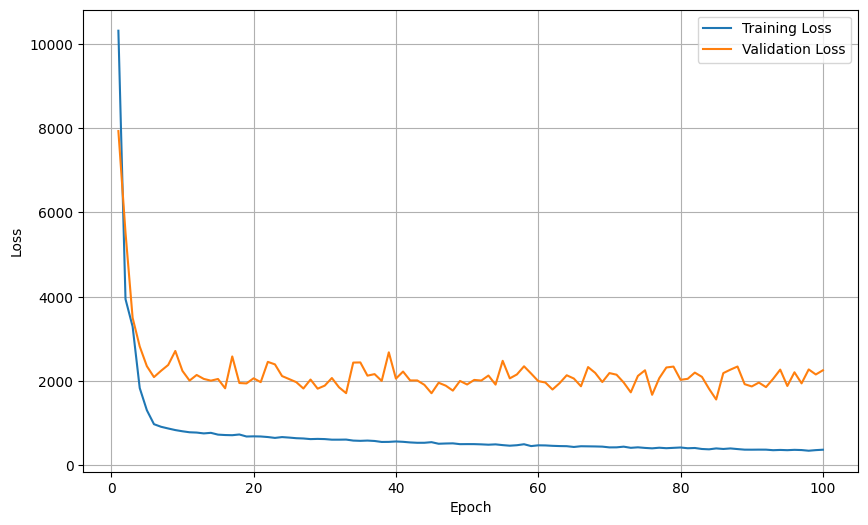

In [ ]:
# Training Loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc='Training'):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

# 5. Plot Training and Validation Loss

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Test MSE Loss: 553.98, L1 Loss: 15.92


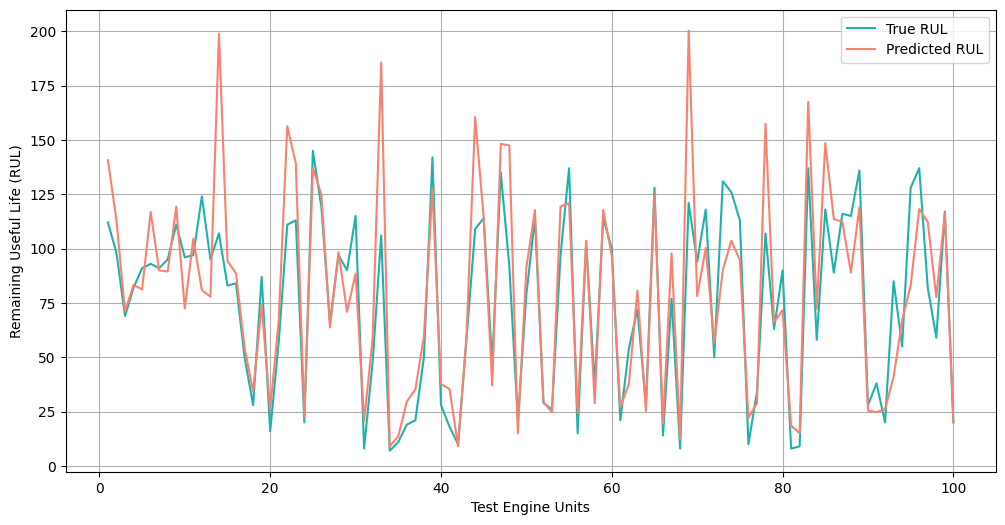

In [ ]:
# Evaluation and Plotting
model.eval()
with torch.no_grad():
    X_test, y_test = next(iter(test_loader))
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)

    test_mse = criterion(y_pred, y_test).item()
    test_l1 = nn.L1Loss()(y_pred, y_test).item()
    print(f'Test MSE Loss: {test_mse:.2f}, L1 Loss: {test_l1:.2f}')

    y_pred = y_pred.detach().cpu().numpy()
    y_test = y_test.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(y_test)+1), y_test, label='True RUL', color='lightseagreen')
plt.plot(range(1, len(y_pred)+1), y_pred, label='Predicted RUL', color='salmon')
plt.xlabel('Test Engine Units')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

model_fd1_lstm = model

## GRU

In [ ]:
class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=12):
        super(GRURegressor, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 1)
        )

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out.squeeze()


# Initialize model, loss function, and optimizer
input_size = len(feature_names)
model = GRURegressor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training:  10%|█         | 10/100 [00:12<01:37,  1.09s/it]

Epoch [10/100], Train Loss: 1414.8535, Val Loss: 2436.8681


Training:  20%|██        | 20/100 [00:23<01:18,  1.02it/s]

Epoch [20/100], Train Loss: 814.4901, Val Loss: 1930.2563


Training:  30%|███       | 30/100 [00:33<01:14,  1.07s/it]

Epoch [30/100], Train Loss: 743.7955, Val Loss: 2534.8777


Training:  40%|████      | 40/100 [00:45<01:05,  1.09s/it]

Epoch [40/100], Train Loss: 726.3368, Val Loss: 2286.8311


Training:  50%|█████     | 50/100 [00:55<00:53,  1.06s/it]

Epoch [50/100], Train Loss: 742.9299, Val Loss: 1759.2358


Training:  60%|██████    | 60/100 [01:06<00:45,  1.13s/it]

Epoch [60/100], Train Loss: 687.5077, Val Loss: 2268.9452


Training:  70%|███████   | 70/100 [01:15<00:29,  1.02it/s]

Epoch [70/100], Train Loss: 725.2835, Val Loss: 1862.7919


Training:  80%|████████  | 80/100 [01:26<00:19,  1.01it/s]

Epoch [80/100], Train Loss: 635.0148, Val Loss: 2152.3679


Training:  90%|█████████ | 90/100 [01:37<00:11,  1.12s/it]

Epoch [90/100], Train Loss: 650.2859, Val Loss: 1978.2760


Training: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]

Epoch [100/100], Train Loss: 632.1758, Val Loss: 1673.9188


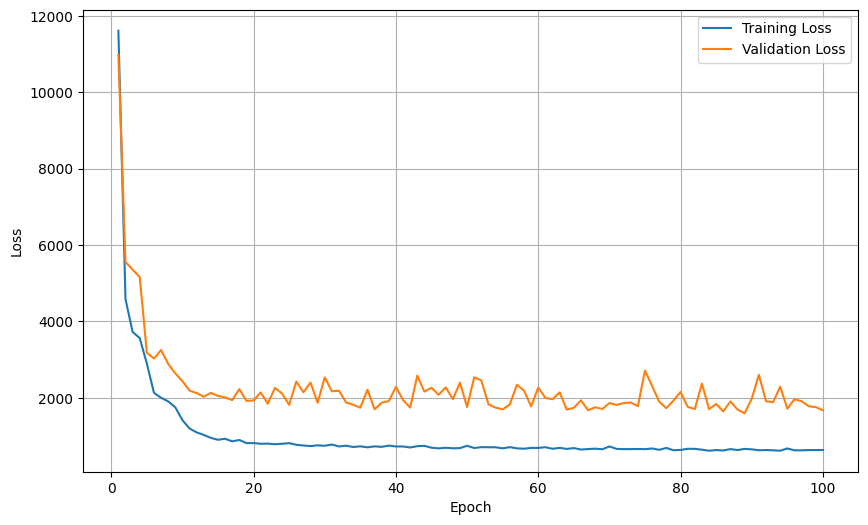

In [ ]:
# Training Loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc='Training'):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

# 5. Plot Training and Validation Loss

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Test MSE Loss: 571.88, L1 Loss: 16.26


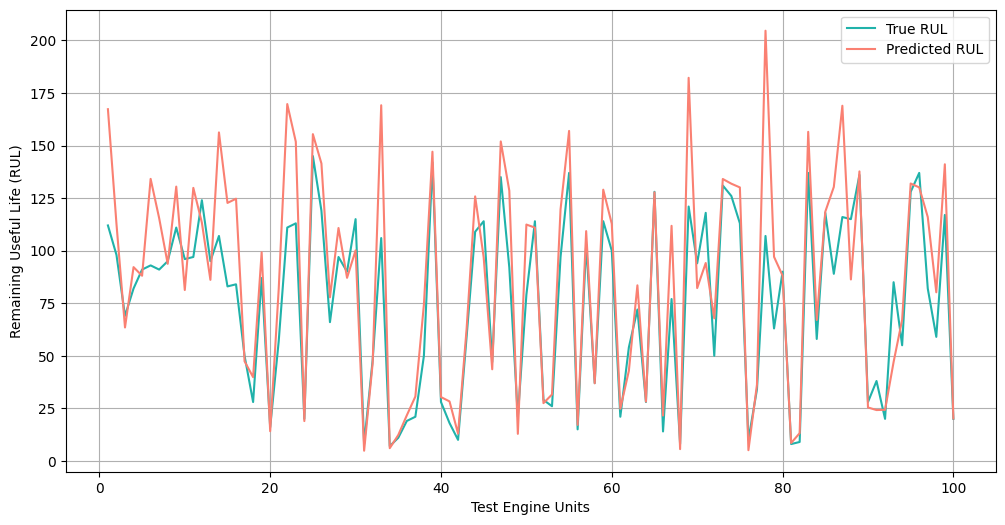

In [ ]:
# Evaluation and Plotting
model.eval()
with torch.no_grad():
    X_test, y_test = next(iter(test_loader))
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)

    test_mse = criterion(y_pred, y_test).item()
    test_l1 = nn.L1Loss()(y_pred, y_test).item()
    print(f'Test MSE Loss: {test_mse:.2f}, L1 Loss: {test_l1:.2f}')

    y_pred = y_pred.detach().cpu().numpy()
    y_test = y_test.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(y_test)+1), y_test, label='True RUL', color='lightseagreen')
plt.plot(range(1, len(y_pred)+1), y_pred, label='Predicted RUL', color='salmon')
plt.xlabel('Test Engine Units')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

model_fd1_gru = model

## Comparing LSTM and GRU

FD001 LSTM Test MSE Loss: 553.98, L1 Loss: 15.92
FD001 GRU Test MSE Loss: 571.88, L1 Loss: 16.26


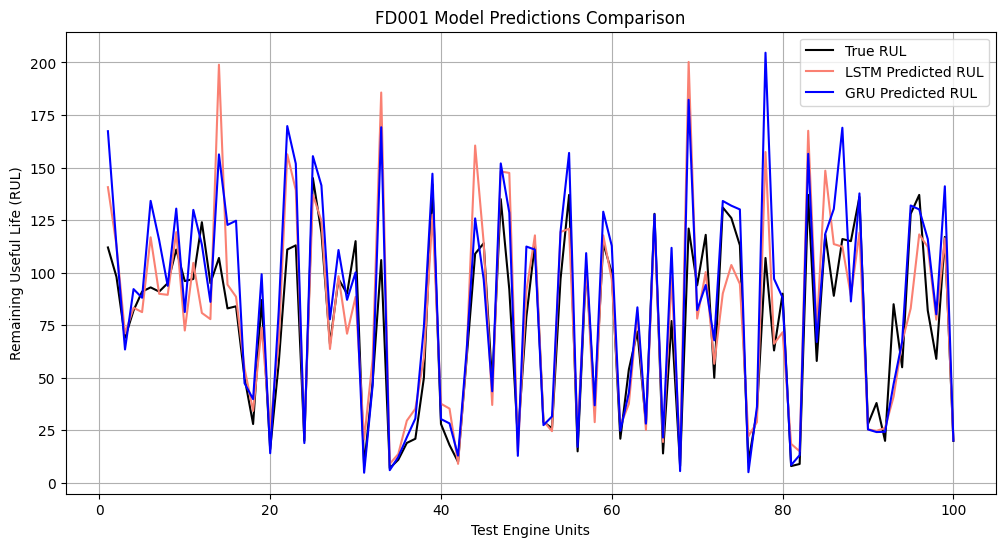

In [ ]:
def plot(test_loader, model_lstm, model_gru, dataset_name):
    # Get test data
    X_test, y_test = next(iter(test_loader))
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Evaluate LSTM model
    model_lstm.eval()
    with torch.no_grad():
        y_pred_lstm = model_lstm(X_test)
        test_mse_lstm = criterion(y_pred_lstm, y_test).item()
        test_l1_lstm = nn.L1Loss()(y_pred_lstm, y_test).item()
        print(f'{dataset_name} LSTM Test MSE Loss: {test_mse_lstm:.2f}, L1 Loss: {test_l1_lstm:.2f}')
        y_pred_lstm = y_pred_lstm.cpu().numpy()

    # Evaluate GRU model
    model_gru.eval()
    with torch.no_grad():
        y_pred_gru = model_gru(X_test)
        test_mse_gru = criterion(y_pred_gru, y_test).item()
        test_l1_gru = nn.L1Loss()(y_pred_gru, y_test).item()
        print(f'{dataset_name} GRU Test MSE Loss: {test_mse_gru:.2f}, L1 Loss: {test_l1_gru:.2f}')
        y_pred_gru = y_pred_gru.cpu().numpy()

    # Move true values to CPU and convert to numpy
    y_true = y_test.cpu().numpy()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(y_true)+1), y_true, label='True RUL', color='black')
    plt.plot(range(1, len(y_pred_lstm)+1), y_pred_lstm, label='LSTM Predicted RUL', color='salmon')
    plt.plot(range(1, len(y_pred_gru)+1), y_pred_gru, label='GRU Predicted RUL', color='blue')
    plt.xlabel('Test Engine Units')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(f'{dataset_name} Model Predictions Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

plot(test_loader, model_fd1_lstm, model_fd1_gru, 'FD001')

As can be seen from the results, LSTM is performing relatively better than GRU for FD001

# FD002 (Bonus)

In [ ]:
dataset    = 'FD002'

# Datasets FD001 to FD004 incorpoate increasing level of complexity and maybe
# used to incrementally learn the effects of faults and operational conditions
# FD001 to FD003 can be regarded as special cases of FD004

# Datasets  , # Fault Models              , # Conditions    , # Train , # Test
# FD001     , # 1 (HPC Degradation)       , # 1 (Sea Level) , # 100   , # 100
# FD002     , # 1 (HPC Degradation)       , # 6             , # 260   , # 259
# FD003     , # 2 (HPC, Fan Degradation)  , # 1 (Sea Level) , # 100   , # 100
# FD004     , # 2 (HPC, Fan Degradation)  , # 6             , # 249   , # 248

train_file = f'/content/train/CMaps/train_{dataset}.txt'
test_file  = f'/content/train/CMaps/test_{dataset}.txt'
truth_file = f'/content/train/CMaps/RUL_{dataset}.txt'

train_df = pd.read_csv(train_file, header = None, sep = ' ').iloc[:, :-2]
test_df  = pd.read_csv(test_file , header = None, sep = ' ').iloc[:, :-2]
truth_df = pd.read_csv(truth_file, header = None)

column_names = [
    # 6 different flight conditions were simulated using 3 operatinal settings
    # Symbol        , # Description
    'unit_ID'       , # ID of each engine instance
    'cycles'        , # Time series (cycles) of sensed measurements
    'alt'           , # Altitude (0-42K ft.)
    'mach'          , # Mach number (0-0.84)
    'tra'           , # Throttle Resolver Angle (20-100)

    # 14 input parameters for engine configs in C-MAPSS
    # Sybmbol       , # Description
    # W_f           , # Fuel flow
    # fan_eff_mod   , # Fan efficiency modifier
    # fan_flow_mod  , # Fan flow modifier
    # fan_PR_mod    , # Fan pressure-ratio modifier
    # LPC_eff_mod   , # LPC efficiency modifier
    # LPC_flow_mod  , # LPC flow modifier
    # LPC_PR_mod    , # LPC pressure-ratio modifier
    # HPC_eff_mod   , # HPC efficiency modifier
    # HPC_flow_mod  , # HPC flow modifier
    # HPC_PR_mod    , # HPC pressure-ratio modifier
    # HPT_eff_mod   , # HPT efficiency modifier
    # HPT_flow_mod  , # HPT flow modifier
    # LPT_eff_mod   , # LPT efficiency modifier
    # LPT_flow_mod  , # HPT flow modifier

    # 21 out of 58 output parameters exposed in the dataset
    # Symbol        , # Description                     , # Units
    'T2'            , # Total temperature at fan inlet  , # °R
    'T24'           , # Total temperature at LPC outlet , # °R
    'T30'           , # Total temperature at HPC outlet , # °R
    'T50'           , # Total temperature at LPT outlet , # °R
    'P2'            , # Pressure at fan inlet           , # psia
    'P15'           , # Total pressure in bypass-duct   , # psia
    'P30'           , # Total pressure at HPC outlet    , # psia
    'Nf'            , # Physical fan speed              , # rpm
    'Nc'            , # Physical core speed             , # rpm
    'epr'           , # Engine pressure ratio (P50/P2)  , # --
    'Ps30'          , # Static pressure at HPC outlet   , # psia
    'phi'           , # Ratio of fuel flow to Ps30      , # pps/psi
    'NRf'           , # Corrected fan speed             , # rpm
    'NRc'           , # Corrected core speed            , # rpm
    'BPR'           , # Bypass Ratio                    , # --
    'farB'          , # Burner fuel-air ratio           , # --
    'htBleed'       , # Bleed Enthalpy                  , # --
    'Nf_dmd'        , # Demanded fan speed              , # rpm
    'PCNfR_dmd'     , # Demanded corrected fan speed    , # rpm
    'W31'           , # HPT coolant bleed               , # lbm/s
    'W32'           , # LPT coolant bleed               , # lbm/s
    ]

    # Hidden parameters for calcuating the Health Index
    # Symbol        , # Description                     , # Units
    # T48 (EGT)     , # Total temperature at HPT outlet , # °R
    # SmFan         , # Fan stall margin                , # --
    # SmLPC         , # LPC stall margin                , # --
    # SmHPC         , # HPC stall margin                , # --

train_df.columns = column_names
test_df.columns = column_names
truth_df.columns = ['RUL']
truth_df['unit_ID'] = truth_df.index + 1


train_df['RUL'] = train_df.groupby('unit_ID')['cycles'].transform('max')
train_df['RUL'] = train_df['RUL'] - train_df['cycles']
test_df = test_df.merge(truth_df, left_on='unit_ID', right_on='unit_ID', how='left')
test_df['RUL'] += test_df.groupby('unit_ID')['cycles'].transform('max')
test_df['RUL'] = test_df['RUL'] - test_df['cycles']

print(train_df.shape, test_df.shape, truth_df.shape)

(53759, 27) (33991, 27) (259, 2)


Text(0.5, 1.0, 'Test')

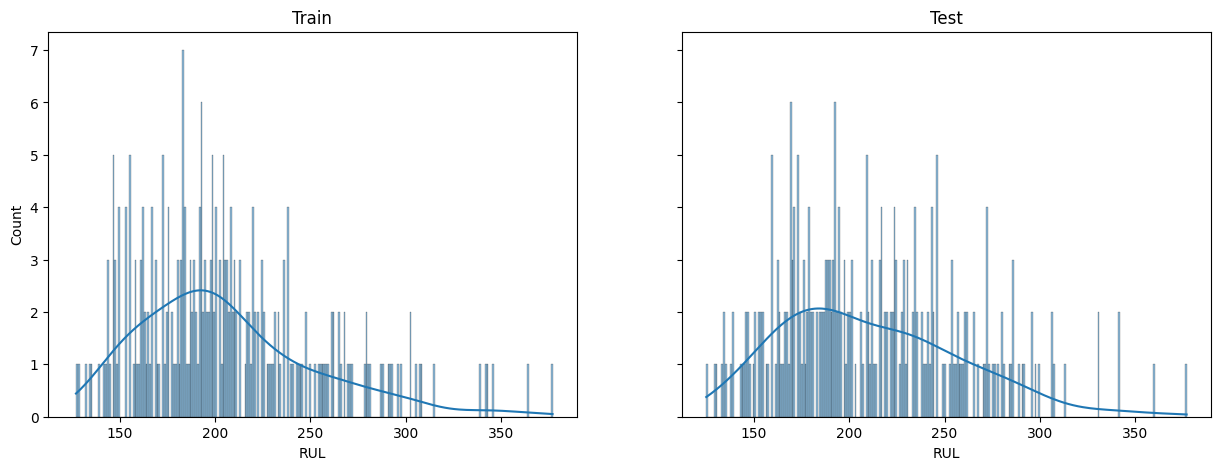

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
sns.histplot(train_df.groupby('unit_ID')['RUL'].max(), kde=True, bins=train_df['unit_ID'].unique().shape[0], ax=axes[0])
sns.histplot(test_df.groupby('unit_ID')['RUL'].max(), kde=True, bins=test_df['unit_ID'].unique().shape[0], ax=axes[1])
axes[0].set_title('Train')
axes[1].set_title('Test')

Text(0.5, 1.0, 'Test')

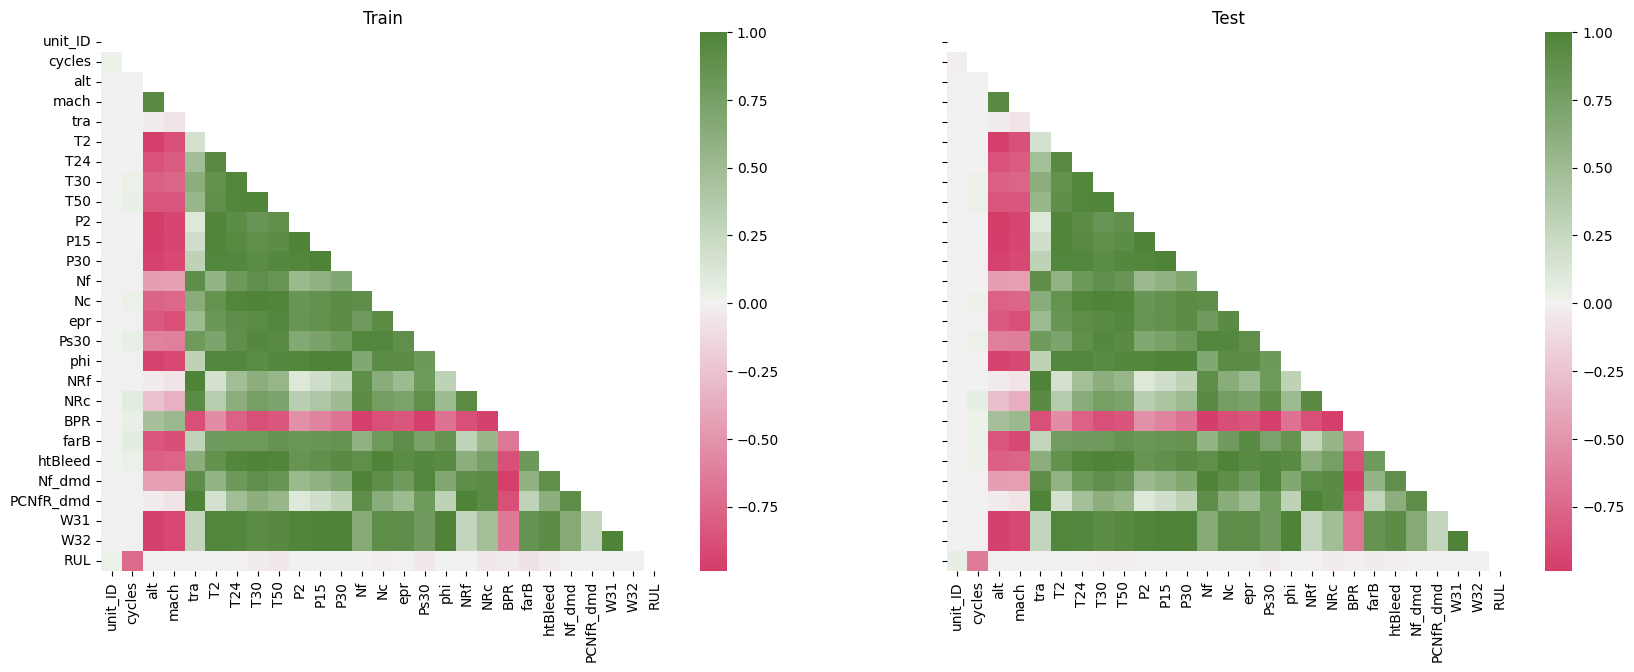

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
sns.heatmap(train_df.corr(),
            mask=np.triu(np.ones_like(train_df.corr(), dtype=bool)),
            cmap=sns.diverging_palette(0, 120, as_cmap=True),
            ax = axes[0]
            )
axes[0].set_title('Train')
sns.heatmap(test_df.corr(),
            mask=np.triu(np.ones_like(test_df.corr(), dtype=bool)),
            cmap=sns.diverging_palette(0, 120, as_cmap=True),
            ax = axes[1]
            )
axes[1].set_title('Test')

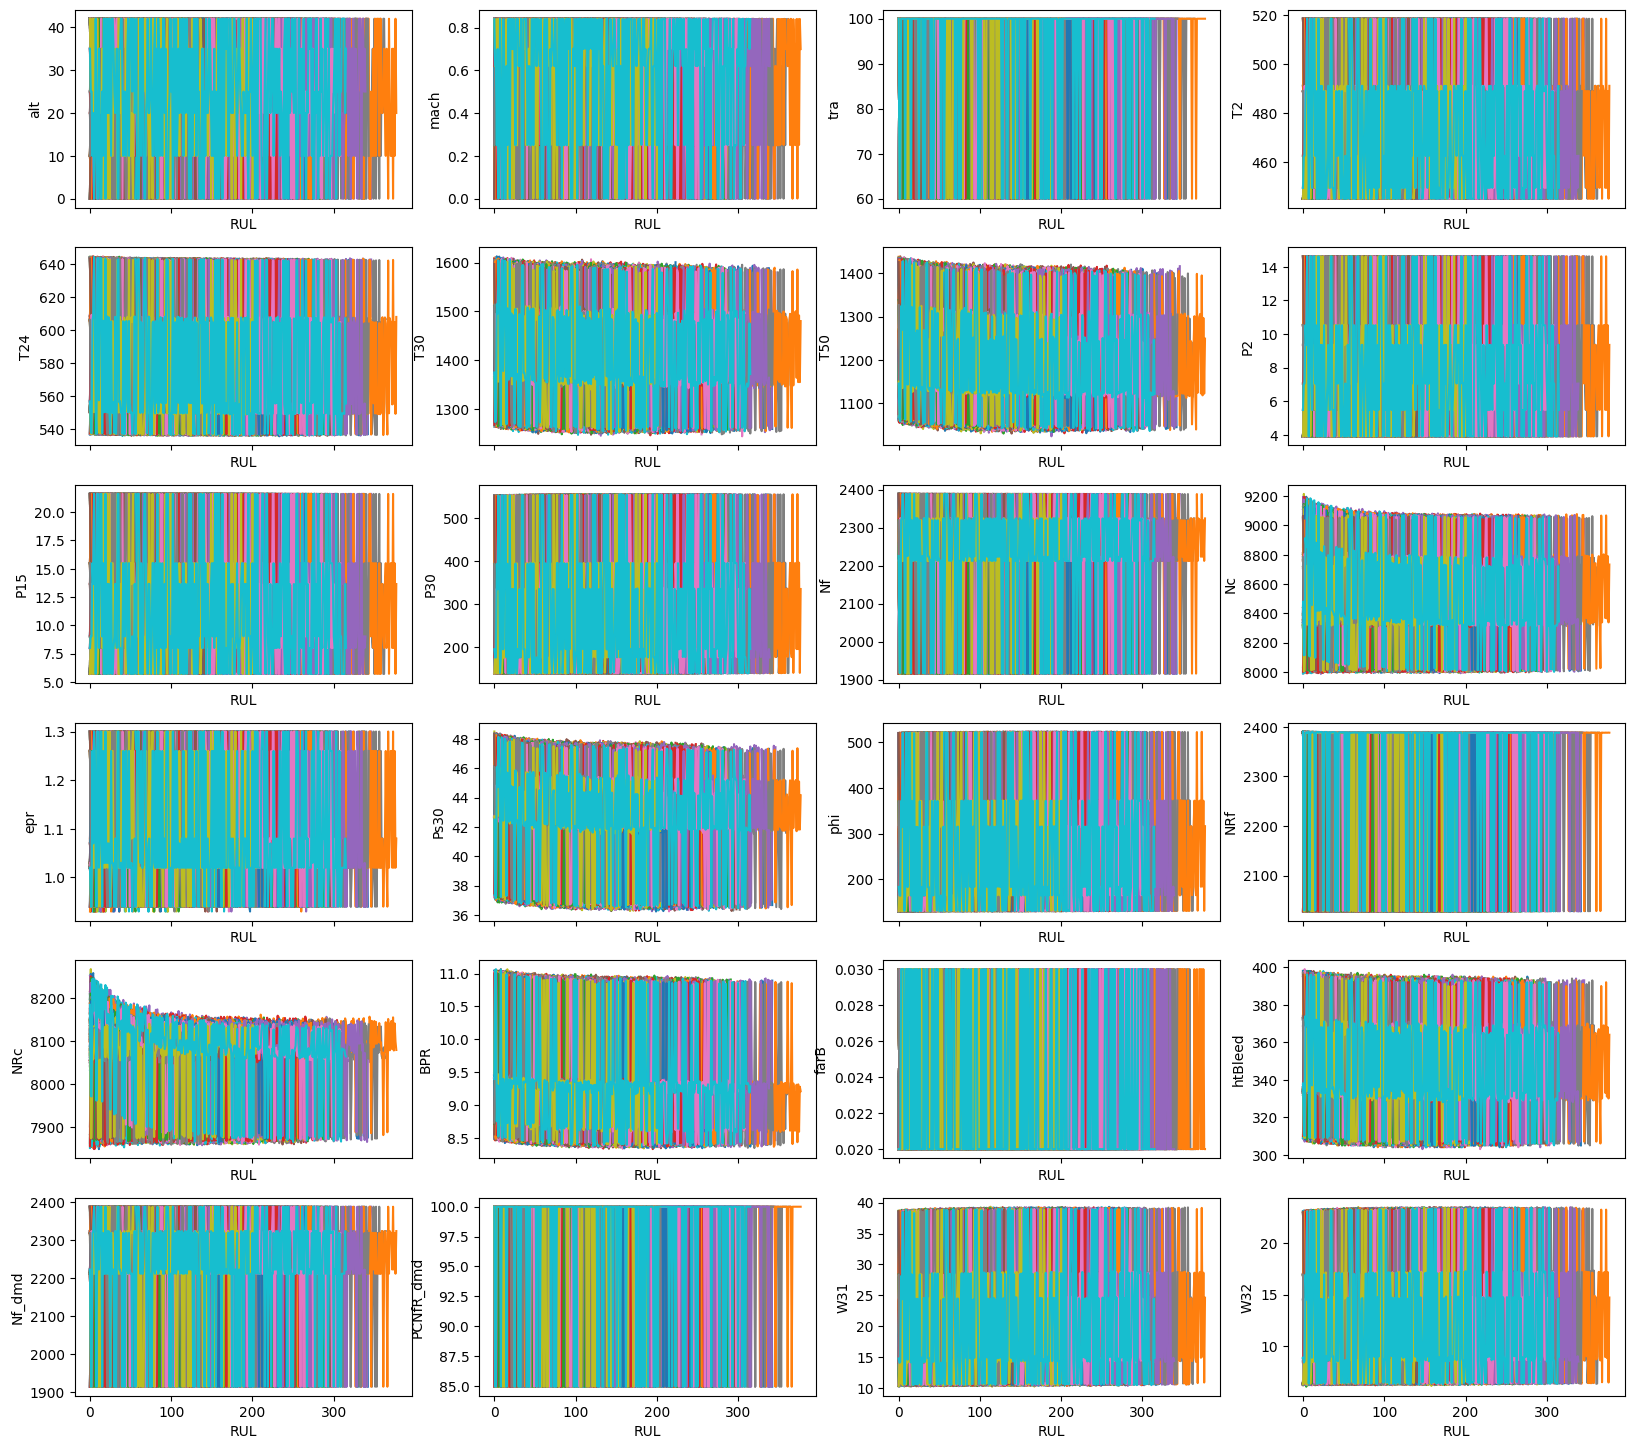

In [ ]:
df = train_df
fig, axes = plt.subplots(6, 4, figsize=(20, 18), sharex=True)

for ax, col in zip(axes.flatten(), df.columns[2:-1]):
    for unit_id in df['unit_ID'].unique():
        unit_data = df[df['unit_ID'] == unit_id]
        ax.plot(unit_data['RUL'], unit_data[col])
    ax.set_ylabel(col)
    ax.set_xlabel('RUL')

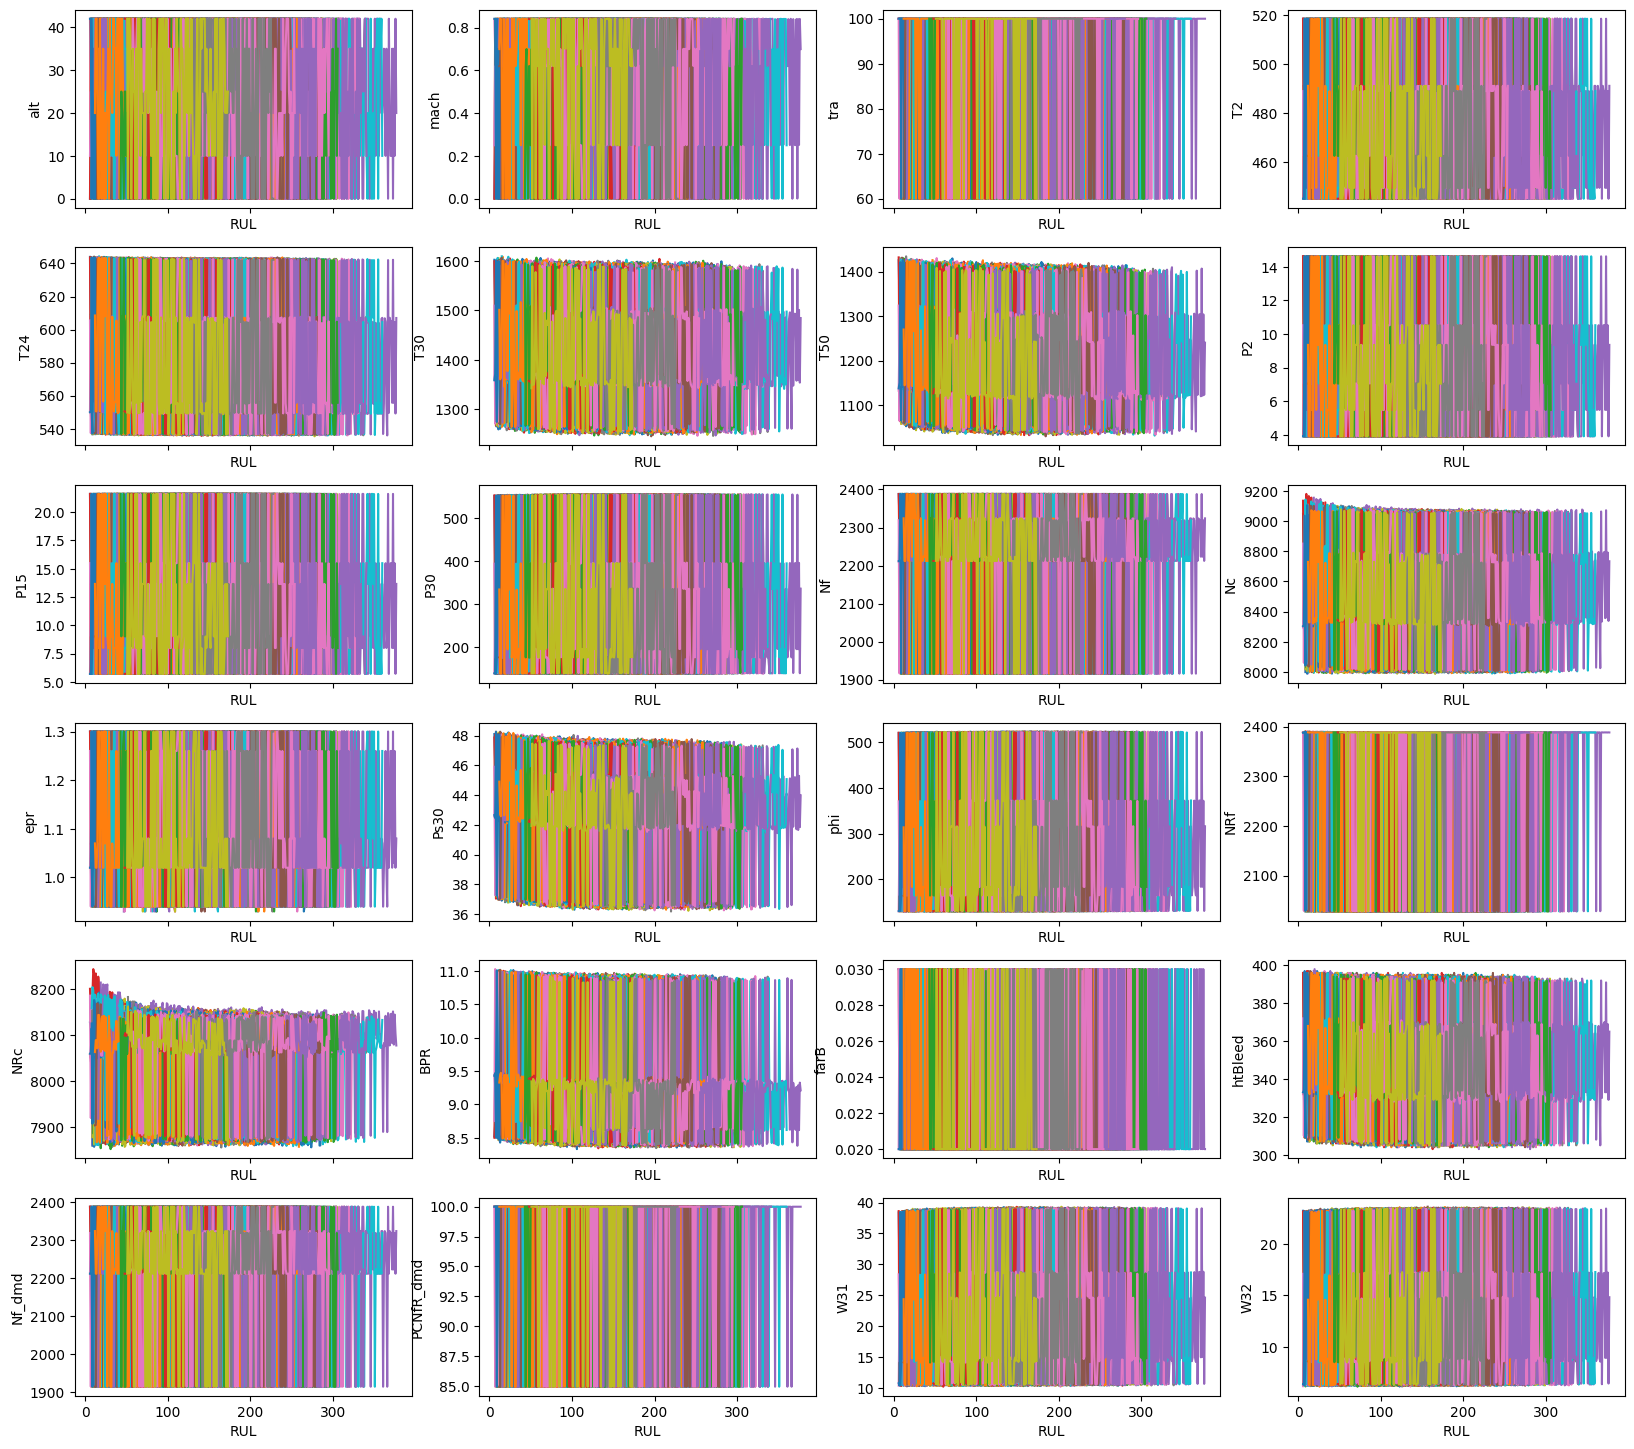

In [ ]:
df = test_df
fig, axes = plt.subplots(6, 4, figsize=(20, 18), sharex=True)

for ax, col in zip(axes.flatten(), df.columns[2:-1]):
    for unit_id in df['unit_ID'].unique():
        unit_data = df[df['unit_ID'] == unit_id]
        ax.plot(unit_data['RUL'], unit_data[col])
    ax.set_ylabel(col)
    ax.set_xlabel('RUL')

Looking at the previous graphs, we are not dropping any columns from this dataset. However, we should still look at the statistics for columns dropped from FD001

In [ ]:
# Comparing against columns dropped for FD001
# No columns to be dropped for FD002
drop_col = ['tra', 'T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
train_df[drop_col].describe().transpose()

count         mean         std      min      25%      50%  \
tra        53759.0    94.046020   14.237735    60.00   100.00   100.00   
T2         53759.0   472.910207   26.389707   445.00   445.00   462.54   
P2         53759.0     8.031986    3.613839     3.91     3.91     7.05   
P15        53759.0    11.600746    5.431802     5.71     5.72     9.03   
epr        53759.0     1.094962    0.127469     0.93     1.02     1.02   
farB       53759.0     0.023326    0.004711     0.02     0.02     0.02   
Nf_dmd     53759.0  2228.806358  145.327980  1915.00  2212.00  2223.00   
PCNfR_dmd  53759.0    97.756838    5.364067    84.93   100.00   100.00   

               75%      max  
tra         100.00   100.00  
T2          491.19   518.67  
P2           10.52    14.62  
P15          15.49    21.61  
epr           1.26     1.30  
farB          0.03     0.03  
Nf_dmd     2324.00  2388.00  
PCNfR_dmd   100.00   100.00

Min-max scaling has been performed to normalize the data. Alternatively, Z-Score normalization could also be performed.

We also performed exponential smoothing to reduce high-frequency noise from the sensor values.

In [ ]:
# Identify feature columns
non_feature_names = ['unit_ID', 'cycles', 'alt', 'mach', 'tra', 'RUL']
feature_names = [col for col in train_df.columns if col not in non_feature_names]

# Min-Max Scaling using training data statistics
min_vals = train_df[feature_names].min()
max_vals = test_df[feature_names].max()

train_df[feature_names] = (train_df[feature_names] - min_vals) / (max_vals - min_vals)
test_df[feature_names] = (test_df[feature_names] - min_vals) / (max_vals - min_vals)

# Exponential Smoothing using pandas
def exponential_smoothing(df, cols, alpha=0.02):
    df_smooth = df.copy()
    for col in cols:
        df_smooth[col] = df_smooth.groupby('unit_ID')[col].transform(
            lambda x: x.ewm(alpha=alpha, adjust=False).mean()
        )
    return df_smooth

train_df = exponential_smoothing(train_df, feature_names)
test_df = exponential_smoothing(test_df, feature_names)

In [ ]:
# Parameters
seq_len = 20
batch_size = 64

# Randomly split units into training and validation sets
units = train_df['unit_ID'].unique()
train_units = np.random.choice(units, int(len(units) * 0.8), replace=False)
val_units = np.setdiff1d(units, train_units)

train_data = train_df[train_df['unit_ID'].isin(train_units)].reset_index(drop=True)
val_data = train_df[train_df['unit_ID'].isin(val_units)].reset_index(drop=True)

# Create datasets
train_dataset = TrainDataset(train_data, seq_len, feature_names)
val_dataset = TrainDataset(val_data, seq_len, feature_names)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Test Dataset and Dataloader
test_dataset = TestDataset(test_df, seq_len, feature_names)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

## LSTM

Training:  10%|█         | 10/100 [00:29<04:32,  3.03s/it]

Epoch [10/100], Train Loss: 4249.1430, Val Loss: 3863.6651


Training:  20%|██        | 20/100 [00:58<03:49,  2.87s/it]

Epoch [20/100], Train Loss: 4248.9087, Val Loss: 3856.7260


Training:  30%|███       | 30/100 [01:28<03:29,  3.00s/it]

Epoch [30/100], Train Loss: 4239.6976, Val Loss: 3843.0981


Training:  40%|████      | 40/100 [01:57<02:53,  2.89s/it]

Epoch [40/100], Train Loss: 1894.8732, Val Loss: 1404.9002


Training:  50%|█████     | 50/100 [02:26<02:22,  2.85s/it]

Epoch [50/100], Train Loss: 1823.3390, Val Loss: 1399.0472


Training:  60%|██████    | 60/100 [02:56<01:59,  2.98s/it]

Epoch [60/100], Train Loss: 1786.9895, Val Loss: 1317.0550


Training:  70%|███████   | 70/100 [03:25<01:30,  3.02s/it]

Epoch [70/100], Train Loss: 1741.1604, Val Loss: 1371.0900


Training:  80%|████████  | 80/100 [03:54<00:56,  2.82s/it]

Epoch [80/100], Train Loss: 1695.4098, Val Loss: 1239.3678


Training:  90%|█████████ | 90/100 [04:24<00:30,  3.01s/it]

Epoch [90/100], Train Loss: 1668.1959, Val Loss: 1282.9613


Training: 100%|██████████| 100/100 [04:53<00:00,  2.93s/it]

Epoch [100/100], Train Loss: 1641.2711, Val Loss: 1207.5374


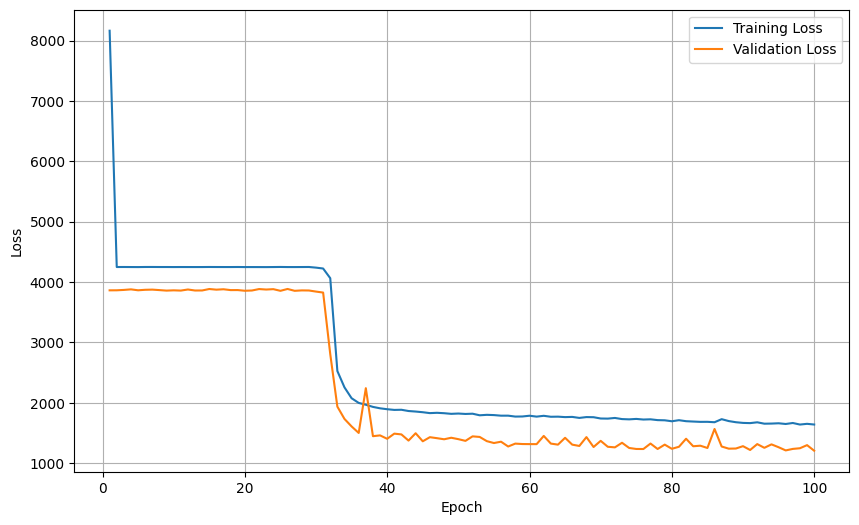

In [ ]:
# Initialize model, loss function, and optimizer
input_size = len(feature_names)
model = LSTMRegressor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc='Training'):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

# 5. Plot Training and Validation Loss

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Test MSE Loss: 1122.76, L1 Loss: 26.10


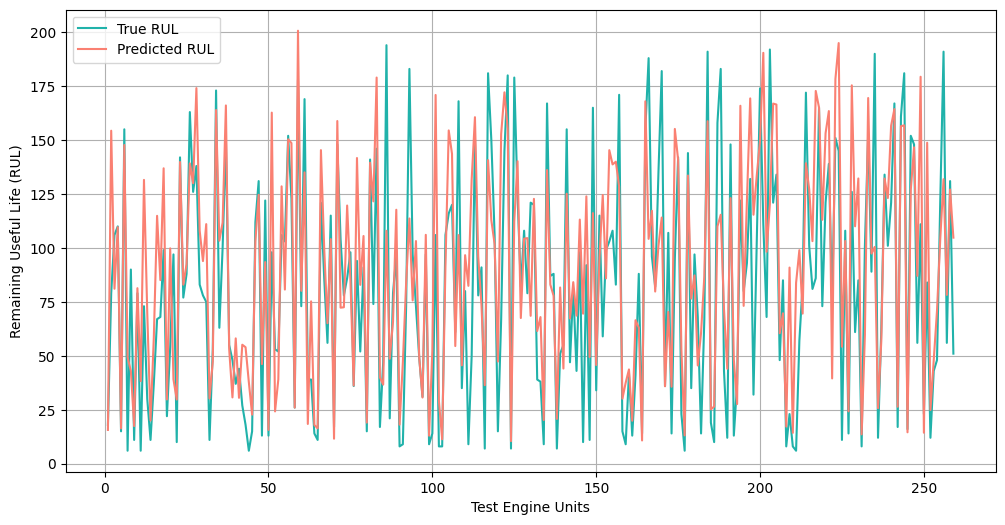

In [ ]:
# Evaluation and Plotting
model.eval()
with torch.no_grad():
    X_test, y_test = next(iter(test_loader))
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)

    test_mse = criterion(y_pred, y_test).item()
    test_l1 = nn.L1Loss()(y_pred, y_test).item()
    print(f'Test MSE Loss: {test_mse:.2f}, L1 Loss: {test_l1:.2f}')

    y_pred = y_pred.detach().cpu().numpy()
    y_test = y_test.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(y_test)+1), y_test, label='True RUL', color='lightseagreen')
plt.plot(range(1, len(y_pred)+1), y_pred, label='Predicted RUL', color='salmon')
plt.xlabel('Test Engine Units')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

model_fd2_lstm = model

## GRU

Training:  10%|█         | 10/100 [00:28<04:17,  2.86s/it]

Epoch [10/100], Train Loss: 4250.0991, Val Loss: 3858.5376


Training:  20%|██        | 20/100 [00:56<03:49,  2.87s/it]

Epoch [20/100], Train Loss: 4249.0708, Val Loss: 3866.6961


Training:  30%|███       | 30/100 [01:23<03:11,  2.74s/it]

Epoch [30/100], Train Loss: 2023.9493, Val Loss: 1443.2576


Training:  40%|████      | 40/100 [01:51<02:42,  2.71s/it]

Epoch [40/100], Train Loss: 1831.0669, Val Loss: 1316.5714


Training:  50%|█████     | 50/100 [02:19<02:22,  2.84s/it]

Epoch [50/100], Train Loss: 1775.3874, Val Loss: 1274.5408


Training:  60%|██████    | 60/100 [02:47<01:52,  2.81s/it]

Epoch [60/100], Train Loss: 1771.7528, Val Loss: 1350.1521


Training:  70%|███████   | 70/100 [03:14<01:22,  2.76s/it]

Epoch [70/100], Train Loss: 1742.8142, Val Loss: 1520.3902


Training:  80%|████████  | 80/100 [03:42<00:54,  2.71s/it]

Epoch [80/100], Train Loss: 1741.6090, Val Loss: 1301.7095


Training:  90%|█████████ | 90/100 [04:10<00:27,  2.74s/it]

Epoch [90/100], Train Loss: 1716.0624, Val Loss: 1300.2936


Training: 100%|██████████| 100/100 [04:39<00:00,  2.79s/it]

Epoch [100/100], Train Loss: 1700.7721, Val Loss: 1330.8716


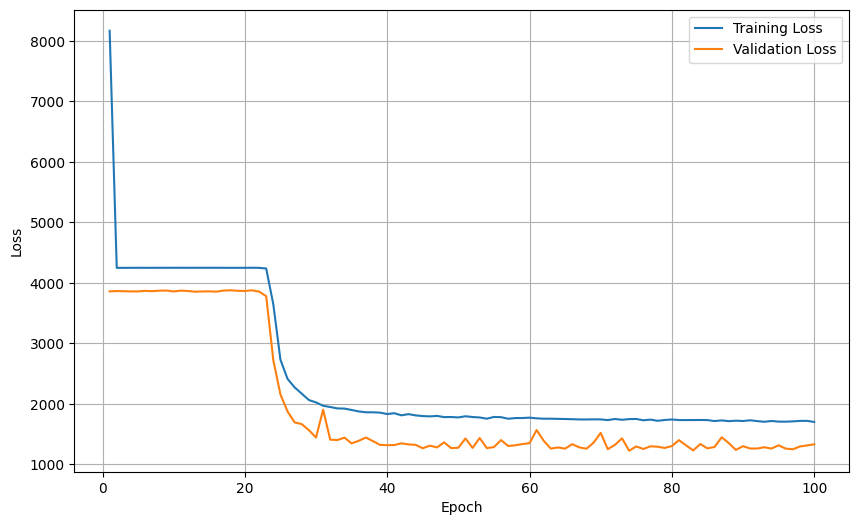

In [ ]:
# Initialize model, loss function, and optimizer
input_size = len(feature_names)
model = GRURegressor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc='Training'):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

# 5. Plot Training and Validation Loss

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Test MSE Loss: 1264.87, L1 Loss: 27.41


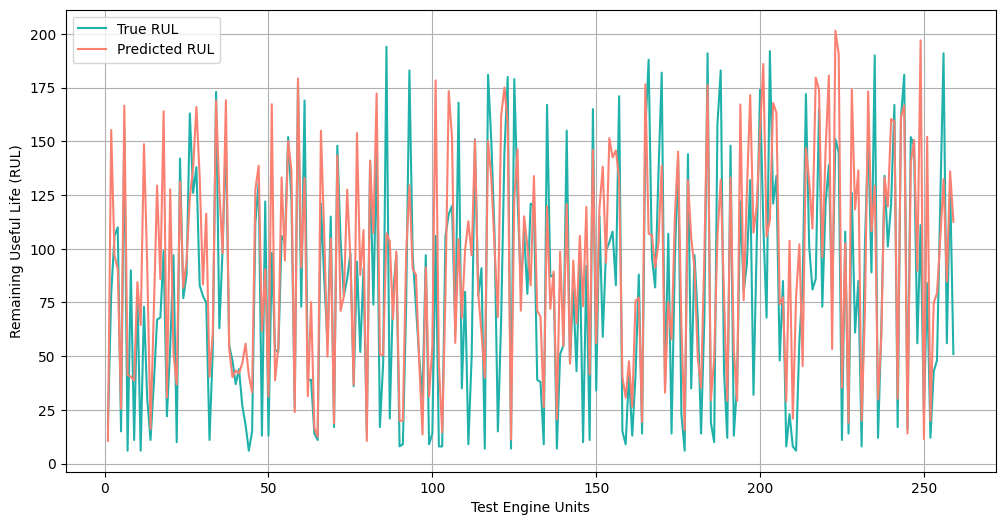

In [ ]:
# Evaluation and Plotting
model.eval()
with torch.no_grad():
    X_test, y_test = next(iter(test_loader))
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)

    test_mse = criterion(y_pred, y_test).item()
    test_l1 = nn.L1Loss()(y_pred, y_test).item()
    print(f'Test MSE Loss: {test_mse:.2f}, L1 Loss: {test_l1:.2f}')

    y_pred = y_pred.detach().cpu().numpy()
    y_test = y_test.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(y_test)+1), y_test, label='True RUL', color='lightseagreen')
plt.plot(range(1, len(y_pred)+1), y_pred, label='Predicted RUL', color='salmon')
plt.xlabel('Test Engine Units')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

model_fd2_gru = model

## Comparing LSTM and GRU

FD002 LSTM Test MSE Loss: 1122.76, L1 Loss: 26.10
FD002 GRU Test MSE Loss: 1264.87, L1 Loss: 27.41


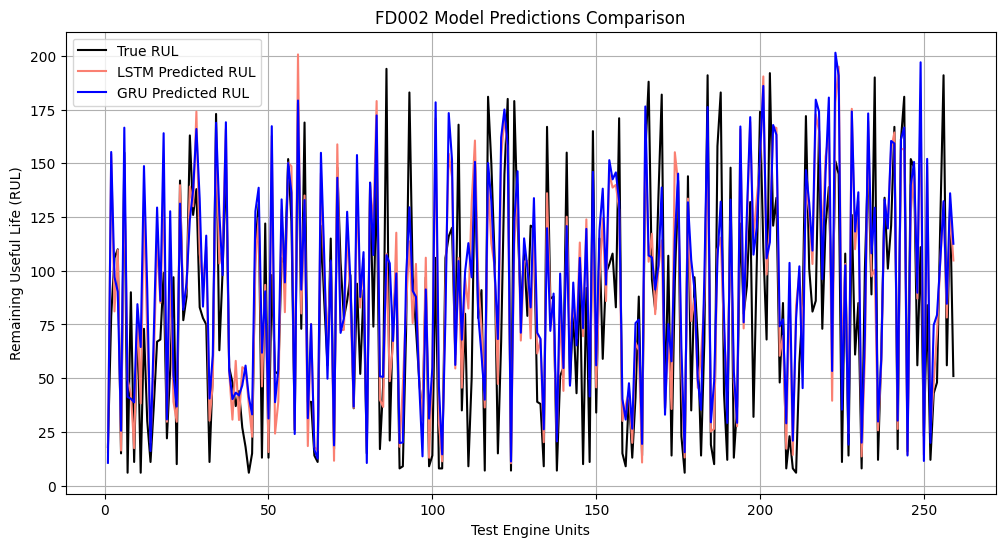

In [ ]:
plot(test_loader, model_fd2_lstm, model_fd2_gru, 'FD002')

As compared to the results from FD001, the difference between LSTM and GRU performance is miniscule in FD002.

# Conclusion and Future Work


While we were able to get good predictive capabilities in both FD001 and FD002 datasets, we can further improve our results by:
* Using CNN instead of exponential smoothing to perform better feature extraction
* Performing automated Neural Architecture Search to find the optimal Network Architecture
* Performing automated Hyperparameter Tuning to find the optimal set of hyperparameters
* Accomodating for unequal sequence lengths by padding the batched dataset using collate_fn, pack_padded_sequence, pad_packed_sequence etc.
* Traning the model on FD004 and evaluating its generalizability across all datasets
* Leveraging Physics Inormed Neural Network techniques to perform model-based learning instead of completely data-driven model-free learning
